In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import healpy as hp
import os
import astropy
import scipy
from scipy.optimize import curve_fit
import math
import glob as gb

In [26]:
#HAWC bins
bin_names = sorted(os.listdir('/data/user/juancarlos/anisotropy/HAWC/local/pass5/reco'))
print(bin_names)

['bin0', 'bin1', 'bin2', 'bin3']


In [27]:
#IceCube data files
directory_path = '/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged'
pattern = 'IC86_24H_sid_*.fits'
IceCube_file_path = gb.glob(directory_path + "/" + pattern)
IceCube_file_path = sorted(IceCube_file_path)

for file_path in IceCube_file_path:
    print(file_path)

/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_4-4.25GeV.fits
/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_4.25-4.5GeV.fits
/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_4.5-4.75GeV.fits
/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_4.75-5GeV.fits
/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_5-5.25GeV.fits
/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_5.25-5.5GeV.fits
/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_5.5-6GeV.fits
/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_6-6.5GeV.fits
/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_6.5-100GeV.fits


IC86_24H_sid_4-4.25GeV.fits


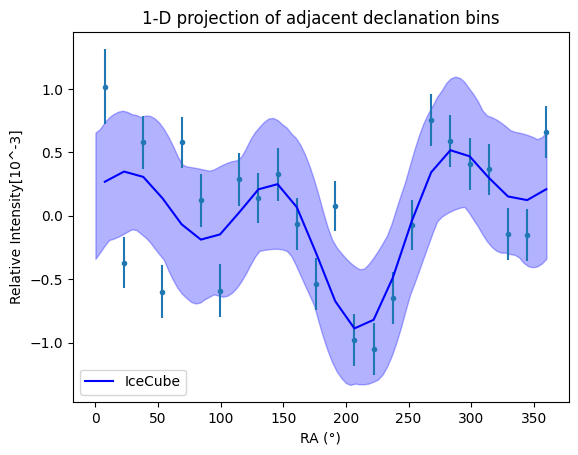


IC86_24H_sid_4.25-4.5GeV.fits


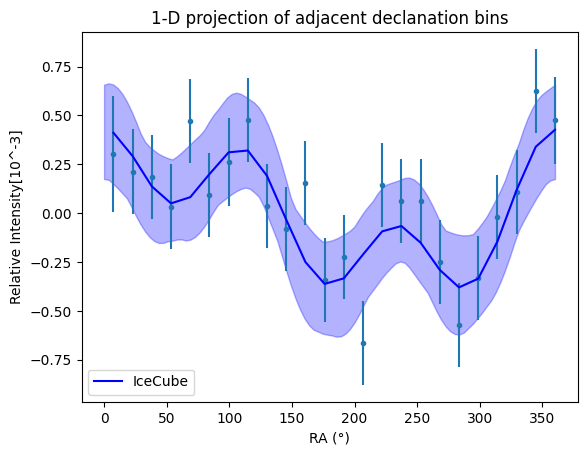


IC86_24H_sid_4.5-4.75GeV.fits


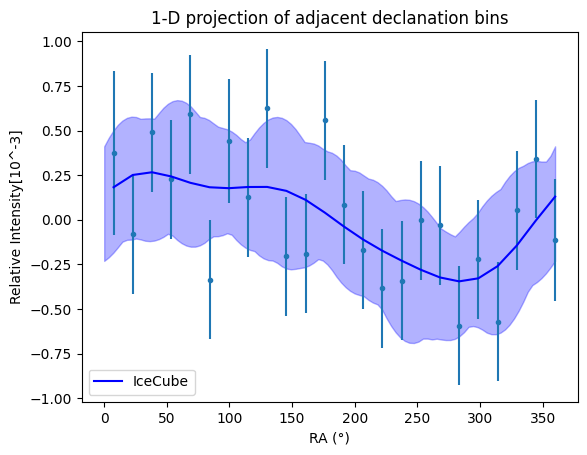


IC86_24H_sid_4.75-5GeV.fits


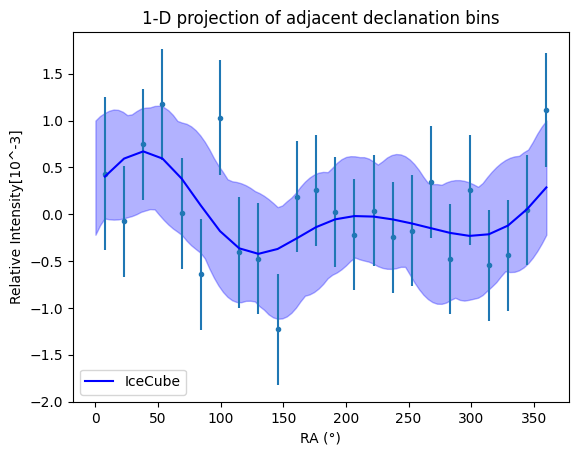


IC86_24H_sid_5-5.25GeV.fits


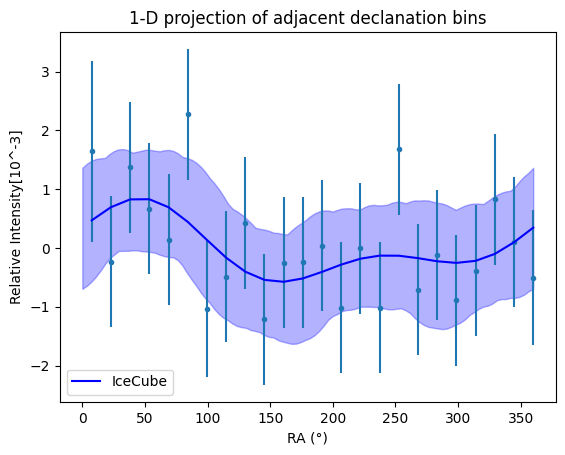


IC86_24H_sid_5.25-5.5GeV.fits


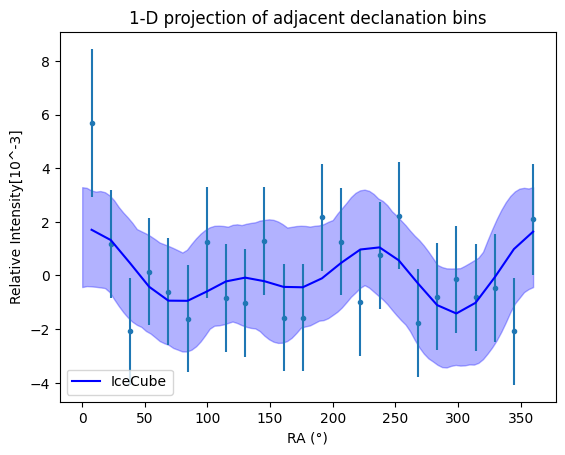


IC86_24H_sid_5.5-6GeV.fits


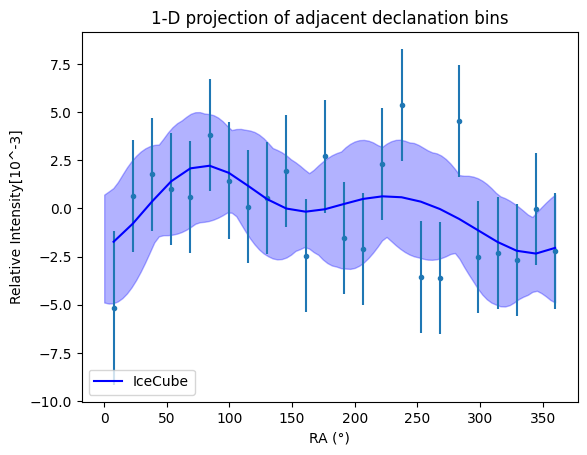


IC86_24H_sid_6-6.5GeV.fits


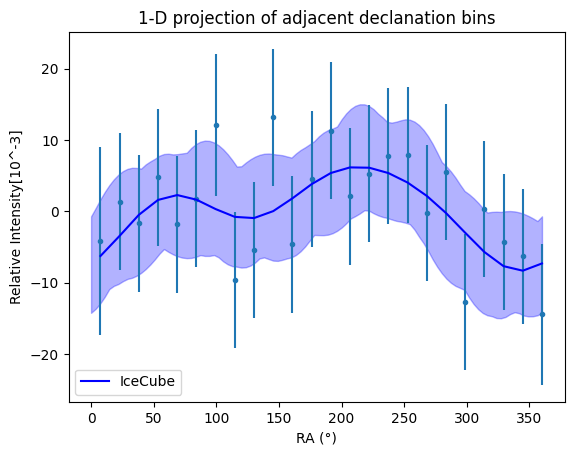

In [44]:
#call this function in the plot_1d_w_errors function
#plot the icecube graph
relative_intensity = []

for file_path in IceCube_file_path:
    
    data_column = hp.read_map(file_path, field = 0)
    
    background_column = hp.read_map(file_path, field = 1)

    #a few values in the data and background were 0, so they couldnt be divided
    #replacing the zero values with nan to get relative intensity
    data_column = np.where((data_column == 0) | np.isnan(data_column), np.nan, data_column)
    background_column = np.where((background_column == 0) | np.isnan(background_column), np.nan, background_column)

    #to see how many number of nan values are there in the arrays
    nan_count_data = np.sum(np.isnan(data_column))
    nan_count_background = np.sum(np.isnan(background_column))

    if nan_count_data == nan_count_background:
        
        #excluding the number of nan values to get only finite values
        data_mask = np.isfinite(data_column)
        background_mask = np.isfinite(background_column)
        data_column = data_column[data_mask]
        background_column = background_column[background_mask]
    
        #the IC86_24H_sid_6.5-100GeV.fits had different number of nan values for data and background, so I will be excluding that file
        relative_intensity = (data_column / background_column) - 1

        print(os.path.basename(file_path))
        plot_id_w_errors_icecube(data_column, background_column, relative_intensity)
        # smooth(file_path, radius = 70, cutoff = False)
        plt.show()
        print()

In [45]:
def plot_id_w_errors_icecube(data, background, relative_intensity, title='Relative Intensity',top=70, bottom=-20,bins=24, alpha = 1):
    
    #IceCube#
    npix = len(data)
    nside = int(math.sqrt(npix/12))

    #pix2ang(nside, ipix[, nest, lonlat]) , lonlot = TURE is right ascension and declanation
    #healpy.query_disc() - will give you a list of pixels in the radius 
    
    min_pix = hp.ang2pix(nside, 0, top, lonlat=True) #defines ranges
    max_pix = hp.ang2pix(nside, 0, bottom, lonlat=True)
    umpix = range(min_pix, max_pix)

    #healpy UNSEEN to mask the values not needed
    relative_intensity[:min_pix] = hp.UNSEEN
    relative_intensity[max_pix:] = hp.UNSEEN
    
    az_bins = np.linspace(np.pi/24, 2*np.pi, bins) #right ascension
    bin_vals = np.zeros(bins) #relative intensity
    bin_counts = np.zeros(bins) #background
    bin_data = np.zeros(bins) #data
    bin_bg = np.zeros(bins)
    zen, az = hp.pix2ang(nside,range(npix))

    for pix in umpix:

        ibin = np.digitize(az[pix], az_bins)
        bin_vals[ibin]+=relative_intensity[pix] #relative intensity
        bin_counts[ibin]+= 1 #1
        bin_data[ibin] += data[pix] #data
        bin_bg[ibin] += background[pix] #background

    yerr2 = np.power(bin_data/bin_bg,2)*(1/bin_data+1/bin_bg/alpha)
    #bin_vals = np.nan_to_num(bin_vals/bin_counts-1)

    ri_fit, ri_cov = curve_fit(func, az_bins, bin_vals/bin_counts)
    #IceCube#

    #Plotting the data#
    # *ri_fit is the unpacked list of the ri_fit array   
    plt.errorbar(np.degrees(az_bins),bin_vals/bin_counts*1e4,yerr=np.sqrt(yerr2)*1e4,fmt='.')
    plt.errorbar(np.degrees(az_bins) , func(az_bins, *ri_fit)*1e4, label = 'IceCube', color = 'blue')
    y_min, y_max = fit_err_band(np.linspace(0,2*np.pi, 100), ri_fit,ri_cov, func)
    plt.fill_between(np.degrees(np.linspace(0,2*np.pi, 100)), y_min*1e4, y_max*1e4, alpha = 0.3, color = 'blue') #alpha is the transparancy
    plt.title("1-D projection of adjacent declanation bins")
    plt.xlabel("RA (°)")
    plt.ylabel("Relative Intensity[10^-3]")
    plt.legend(loc = 'lower left')

In [30]:
#this is the function for the dipole + quadropole + octopole
def func(x, A1, phi1, A2, phi2, A3, phi3):
    return (A1 * np.cos(x + phi1)) + (A2 * np.cos(2*x + phi2)) + (A3 * np.cos(3*x + phi3))

In [31]:
def fit_err_band(x, ri_fit, ri_cov, func):
    ymax = -np.ones(len(x))*np.inf
    ymin = np.ones(len(x))*np.inf
    errs = np.sqrt(np.diag(ri_cov))
    for i in range(-1,2):
        for j in range(-1,2):
            for k in range(-1,2):
                for l in range(-1,2):
                    for m in range(-1,2):
                        for n in range(-1,2):
                            pvals = np.array(ri_fit) + np.array(errs)*np.array([i,j,k,l,m,n]) 
                            ymin = np.minimum(ymin, func(x,*pvals)) 
                            ymax = np.maximum(ymax, func(x,*pvals)) 
                            
    return ymin, ymax

In [32]:
def smooth(relative_intensity_filepath, radius = 10, cutoff = True): #List of filepaths, radius of tophat smoothing
    #Change degree to radians
    radius = math.radians(radius)
    
    #Loop over all filepaths in list
    # for i in range(len(relative_intensity_filepath)):
    #Select current relative_intensity array
    relative_intensity = hp.read_map(relative_intensity_filepath)

    #Calculate Nside (num_pix = 12*Nside**2) Note: should be 64
    num_pix = len(relative_intensity)
    Nside = int(math.sqrt(num_pix/12))

    #Calculate indices for Lat 70 and Lat 20
    top_val = hp.pixelfunc.ang2pix(Nside, 0, 70, lonlat = True)
    bottom_val = hp.pixelfunc.ang2pix(Nside, 0, -20, lonlat = True)
    #Remove all values outside of the indices
    for j in range(len(relative_intensity)):
        if j > bottom_val or j < top_val:
            relative_intensity[j] = 0

    #Smooth all pixels by taking the average of its neighbors
    for pixel in range(len(relative_intensity)):
        #Get list of all pixels surrounding each pixel with radius R
        theta, phi = hp.pixelfunc.pix2ang(Nside, pixel)
        vec = hp.pixelfunc.ang2vec(theta, phi)
        list_pix = hp.query_disc(Nside, vec, radius)   
        #Set original pixel to that average value
        relative_intensity[pixel] = relative_intensity[list_pix].mean()


    #Call mollview to show graph Note: Cutoff manually sets the bounds for the values to be between +- 1e-3
    if cutoff == True:
        hp.mollview(relative_intensity, min = -1e-3, max = 1e-3)          
    elif cutoff == False:
        hp.mollview(relative_intensity)
        
    return relative_intensity
  

In [33]:
def plot_1d_w_errrors(data,backgroung,relative_intensity,title='Relative Intensity',top=70, bottom=-20,bins=24, alpha = 1):
    
    #HAWC#
    npix = len(data)
    nside = hp.npix2nside(npix)  #how to divide the sky , nside 64

    #pix2ang(nside, ipix[, nest, lonlat]) , lonlot = TURE is right ascension and declanation
    #healpy.query_disc() - will give you a list of pixels in the radius 
    
    min_pix = hp.ang2pix(nside, 0, top, lonlat=True) #defines ranges
    max_pix = hp.ang2pix(nside, 0, bottom, lonlat=True)
    umpix = range(min_pix, max_pix)

    #healpy UNSEEN to mask the values not needed
    relative_intensity[:min_pix] = hp.UNSEEN
    relative_intensity[max_pix:] = hp.UNSEEN
    
    az_bins = np.linspace(np.pi/24, 2*np.pi, bins) #right ascension
    bin_vals = np.zeros(bins) #relative intensity
    bin_counts = np.zeros(bins) #background
    bin_data = np.zeros(bins) #data
    bin_bg = np.zeros(bins)
    zen, az = hp.pix2ang(nside,range(npix))

    for pix in umpix:

        ibin = np.digitize(az[pix], az_bins)
        bin_vals[ibin]+=relative_intensity[pix] #relative intensity
        bin_counts[ibin]+= 1 #1
        bin_data[ibin] += data[pix] #data
        bin_bg[ibin] += background[pix] #background

    yerr2 = np.power(bin_data/bin_bg,2)*(1/bin_data+1/bin_bg/alpha)
    #bin_vals = np.nan_to_num(bin_vals/bin_counts-1)

    ri_fit, ri_cov = curve_fit(func, az_bins, bin_vals/bin_counts)
    #HAWC#

    #Plotting the data#
    # *ri_fit is the unpacked list of the ri_fit array   
    plt.errorbar(np.degrees(az_bins),bin_vals/bin_counts*1e4,yerr=np.sqrt(yerr2)*1e4,fmt='.')
    plt.errorbar(np.degrees(az_bins) , func(az_bins, *ri_fit)*1e4, label = 'HAWC')
    y_min, y_max = fit_err_band(np.linspace(0,2*np.pi, 100), ri_fit,ri_cov, func)
    plt.fill_between(np.degrees(np.linspace(0,2*np.pi, 100)), y_min*1e4, y_max*1e4, alpha = 0.3, color = 'orange') #alpha is the transparancy
    plt.title("1-D projection of adjacent declanation bins")
    plt.xlabel("RA (°)")
    plt.ylabel("Relative Intensity[10^-3]")
    plt.legend(loc = 'lower left')
    # hp.mollview(relative_intensity)
    #Plotting the data#

bin0


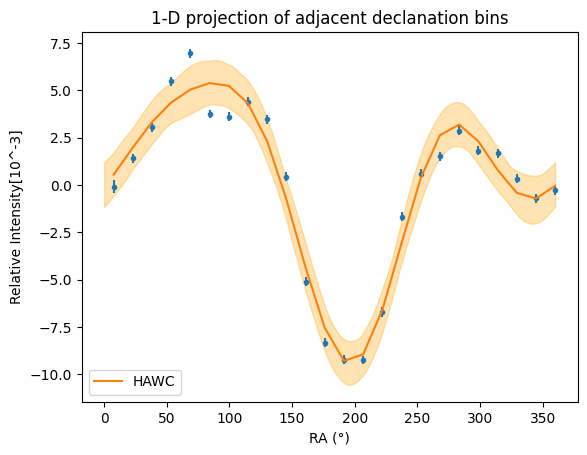

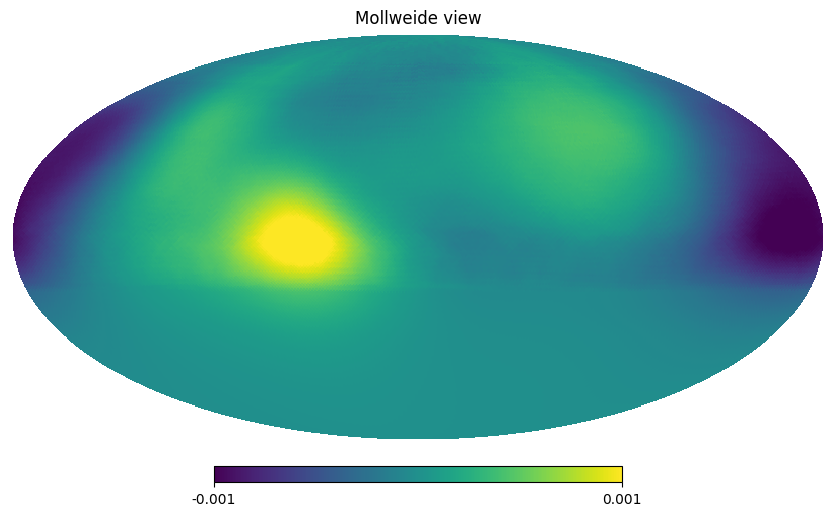

bin1


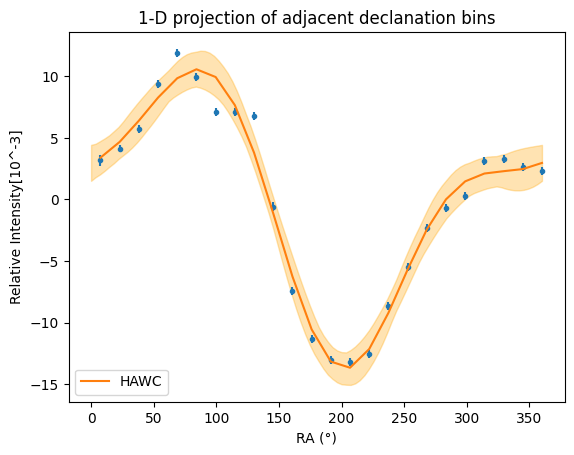

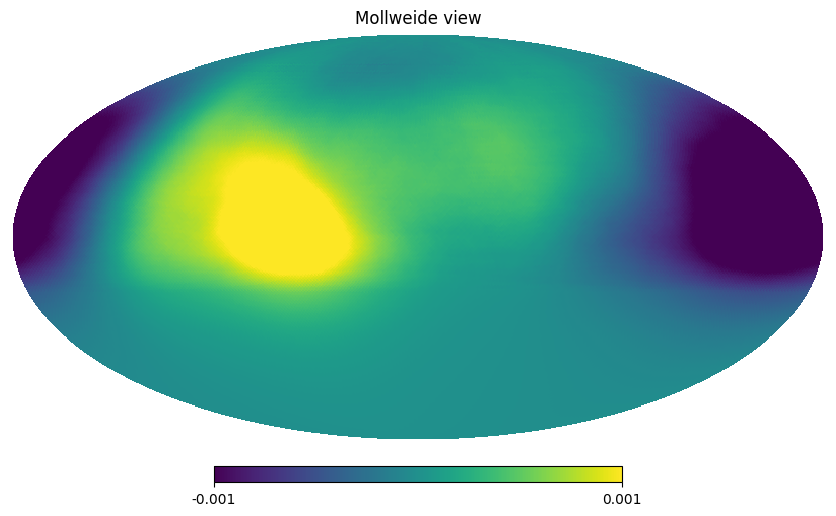

bin2


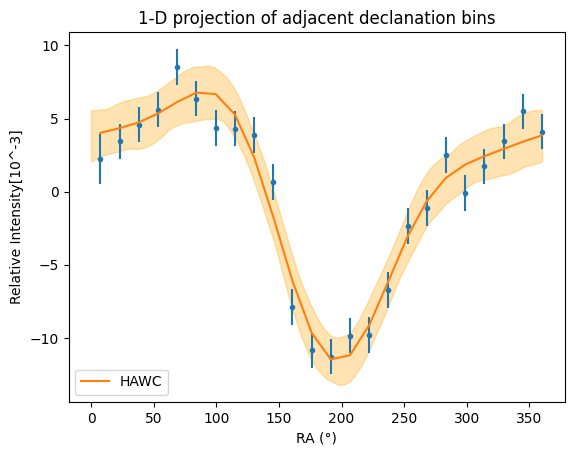

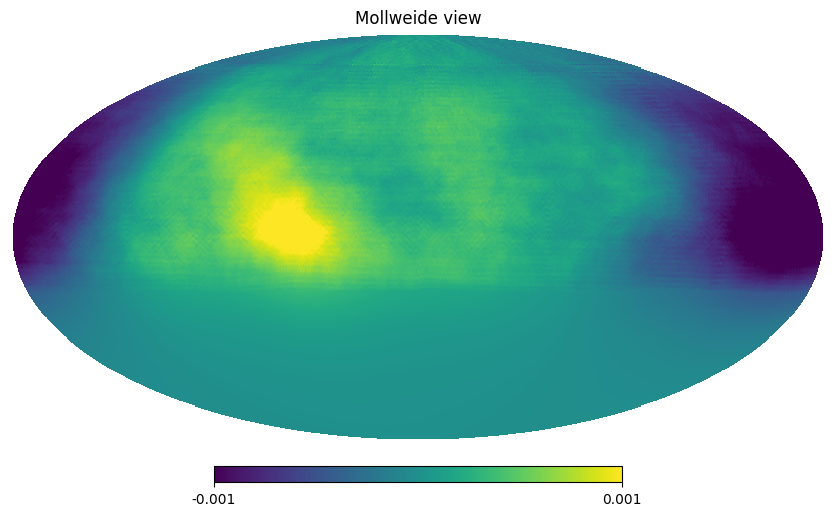

bin3


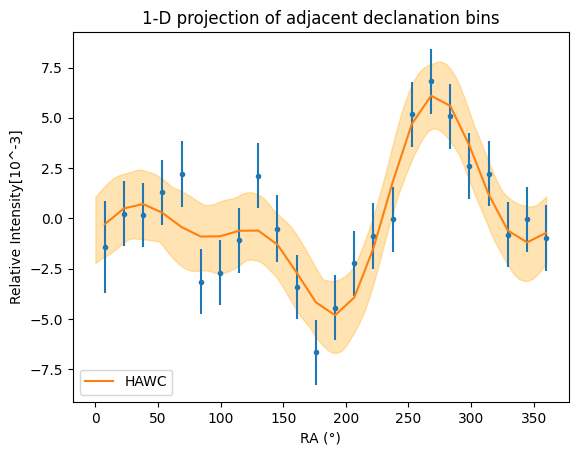

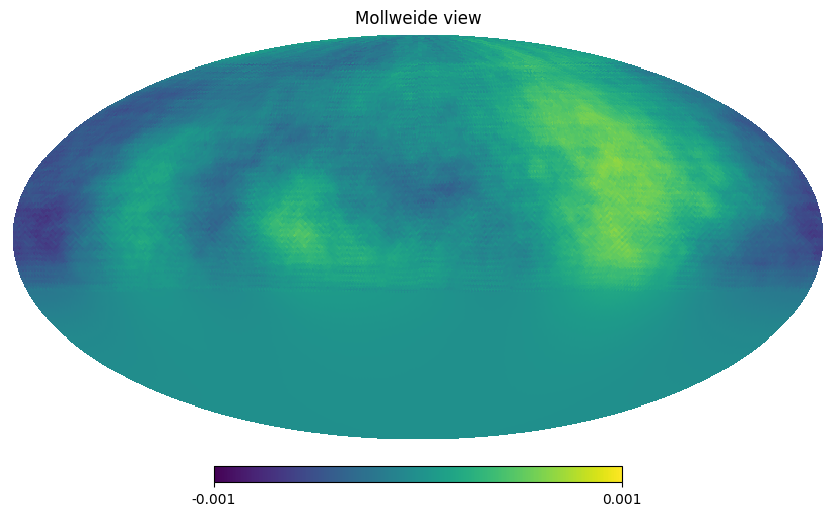

In [34]:
#plot the healpy graph in this for loop only

for bin_name in bin_names:
    data_path = '/data/user/juancarlos/anisotropy/HAWC/local/pass5/reco/{0}/data_HAWC_64_360.fits'.format(bin_name)
    data = hp.read_map(data_path)
    
    relative_intensity_path = '/data/user/juancarlos/anisotropy/HAWC/local/pass5/reco/{0}/CR_HAWC_64_360_iteration20.fits'.format(bin_name)
    relative_intensity = hp.read_map(relative_intensity_path)
    
    #relative_intensity = (data/background) - 1
    background = data / (relative_intensity + 1)
    
    print(bin_name)
    plot_1d_w_errrors(data,background,relative_intensity)
    smooth(relative_intensity_path, radius = 20)
    plt.show()